In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import shutil

In [3]:
!mkdir /content/datasets
shutil.unpack_archive("/content/drive/MyDrive/DSforBiz/Character_Images.zip", "/content/datasets", 'zip')

In [4]:
shutil.copy("/content/drive/MyDrive/DSforBiz/Labels.txt","/content/datasets")

'/content/datasets/Labels.txt'

## Data Augmentation

We utilize Keras' own generator `ImageDataGenerator` for data augmentation: rotate, shift, shear and zoom in/out. We did not performe data augmentation on the sharpness, light and shadow, of the images, because we don't need the ability to generalize across multiple scenarios since our test data was obtained on the same hardware as the training data.


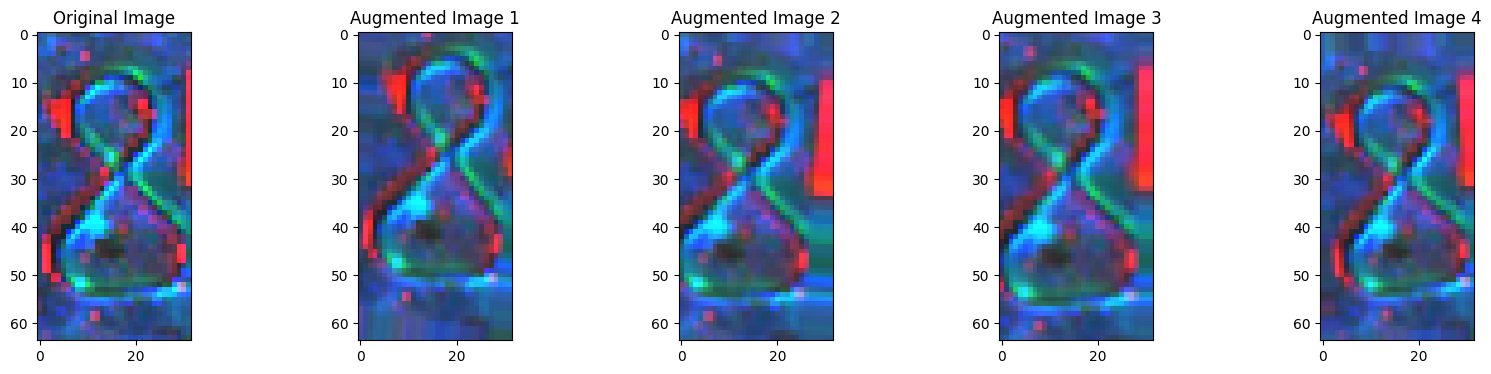

In [7]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import imageio

# Load the image
image_path = '/content/datasets/Character_Images/sample_00222.png'
image = imageio.v2.imread(image_path)
image = np.expand_dims(image, 0)  # Reshape image to (1, height, width, channels)

# Define the data augmentation generator
gen = ImageDataGenerator(
    rotation_range=8,      # Rotate the image by up to 8 degrees
    width_shift_range=0.08,  # Horizontally shift the image by 8% of the width
    shear_range=0.3,         # Shear the image by 30%
    height_shift_range=0.08, # Vertically shift the image by 8% of the height
    zoom_range=0.08          # Zoom in/out by 8%
)

# Prepare for plotting
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
ax[0].imshow(image[0])
ax[0].set_title('Original Image')

# Display augmented images
for i in range(1, 5):
    for batch in gen.flow(image, batch_size=1):
        ax[i].imshow(batch[0].astype('uint8'))
        ax[i].set_title(f'Augmented Image {i}')
        break

plt.show()


## Experimental Setup
1. Load the data and labels and keep them in a proper format in the memory
2. Store the images according to the category of the label
3. Split the dataset for train and test (80/20)
4. Define data generator for keras model

In [8]:
!mkdir /content/datasets/Categorized_Character_images

In [9]:
from sklearn.model_selection import train_test_split

# Paths to the folders and labels file
image_folder = '/content/datasets/Character_Images'
labels_file = '/content/datasets/Labels.txt'
categorized_folder = '/content/datasets/Categorized_Character_images'
train_folder = os.path.join(categorized_folder, 'train')
test_folder = os.path.join(categorized_folder, 'test')

# Read labels and append .png extension
labels = {}
with open(labels_file, 'r') as file:
    for line in file:
        key, value = line.strip().split(',')
        filename_with_extension = f"{key.strip()}.png"
        labels[filename_with_extension] = value.strip()

# Create train and test folders for each label
for label in set(labels.values()):
    os.makedirs(os.path.join(train_folder, label), exist_ok=True)
    os.makedirs(os.path.join(test_folder, label), exist_ok=True)

# Split filenames into train and test sets
filenames = list(labels.keys())
train_filenames, test_filenames = train_test_split(filenames, test_size=0.2, random_state=42)

# Function to copy files to respective folders
def copy_files(filenames, src_folder, dst_folder):
    for filename in filenames:
        label = labels[filename]
        src_path = os.path.join(src_folder, filename)
        dst_path = os.path.join(dst_folder, label, filename)
        if not os.path.exists(src_path):
            print(f"File not found: {src_path}")
            continue
        shutil.copy(src_path, dst_path)

# Copy files to train and test folders
copy_files(train_filenames, image_folder, train_folder)
copy_files(test_filenames, image_folder, test_folder)

print("Files have been organized into train and test folders.")


Files have been organized into train and test folders.


In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = gen
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(32, 64),
    batch_size=64,
    class_mode='categorical' # For category task
)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(32, 64),
    batch_size=64,
    class_mode='categorical'
)

Found 59954 images belonging to 13 classes.
Found 14989 images belonging to 13 classes.


## Model
Our model is a deep Convolutional Neural Network (CNN) built using TensorFlow and Keras, specifically designed to process color images of size 32x64 (with 3 color channels). It contains the following main parts:

- Convolutional Layers
- Batch Normalization
- Activation Function
- Flatten Layer
- Fully Connected Layer
- Dropout
- Output Layer (Fully connect layer)

In [14]:
import random                        

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = Sequential()

# Convolution Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(32, 64, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

# Convolution Layer 2
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution Layer 3
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

# Convolution Layer 4
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

# Fully Connected Layer 5
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Fully Connected Layer 6
model.add(Dropout(0.2))
model.add(Dense(13))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training

We performed 30 epochs of training in 3 sessions. This helps us to better monitor the model's training performance.

In [15]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

Epoch 1/10
937/937 [==============================] - 95s 99ms/step - loss: 0.1587 - accuracy: 0.9529 - val_loss: 0.0768 - val_accuracy: 0.9741
Epoch 2/10
937/937 [==============================] - 92s 99ms/step - loss: 0.0425 - accuracy: 0.9873 - val_loss: 0.0257 - val_accuracy: 0.9913
Epoch 3/10
937/937 [==============================] - 94s 100ms/step - loss: 0.0288 - accuracy: 0.9917 - val_loss: 0.0163 - val_accuracy: 0.9947
Epoch 4/10
937/937 [==============================] - 91s 97ms/step - loss: 0.0233 - accuracy: 0.9927 - val_loss: 0.0103 - val_accuracy: 0.9975
Epoch 5/10
937/937 [==============================] - 91s 97ms/step - loss: 0.0198 - accuracy: 0.9937 - val_loss: 0.0071 - val_accuracy: 0.9978
Epoch 6/10
937/937 [==============================] - 90s 96ms/step - loss: 0.0194 - accuracy: 0.9935 - val_loss: 0.0069 - val_accuracy: 0.9980
Epoch 7/10
937/937 [==============================] - 95s 102ms/step - loss: 0.0164 - accuracy: 0.9950 - val_loss: 0.0468 - val_accurac

In [17]:
additional_history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

Epoch 1/10
937/937 [==============================] - 93s 99ms/step - loss: 0.0106 - accuracy: 0.9965 - val_loss: 0.0093 - val_accuracy: 0.9971
Epoch 2/10
937/937 [==============================] - 89s 95ms/step - loss: 0.0105 - accuracy: 0.9968 - val_loss: 0.0077 - val_accuracy: 0.9980
Epoch 3/10
937/937 [==============================] - 90s 96ms/step - loss: 0.0095 - accuracy: 0.9969 - val_loss: 0.0090 - val_accuracy: 0.9976
Epoch 4/10
937/937 [==============================] - 90s 96ms/step - loss: 0.0092 - accuracy: 0.9970 - val_loss: 0.0060 - val_accuracy: 0.9987
Epoch 5/10
937/937 [==============================] - 92s 98ms/step - loss: 0.0082 - accuracy: 0.9974 - val_loss: 0.0065 - val_accuracy: 0.9984
Epoch 6/10
937/937 [==============================] - 90s 96ms/step - loss: 0.0078 - accuracy: 0.9973 - val_loss: 0.0067 - val_accuracy: 0.9987
Epoch 7/10
937/937 [==============================] - 91s 98ms/step - loss: 0.0071 - accuracy: 0.9977 - val_loss: 0.0111 - val_accuracy:

In [18]:
full_history = {
    'loss': history.history['loss'] + additional_history.history['loss'],
    'accuracy': history.history['accuracy'] + additional_history.history['accuracy'],
    'val_loss': history.history['val_loss'] + additional_history.history['val_loss'],
    'val_accuracy': history.history['val_accuracy'] + additional_history.history['val_accuracy']
}

In [19]:
additional_history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

Epoch 1/10
937/937 [==============================] - 95s 101ms/step - loss: 0.0055 - accuracy: 0.9981 - val_loss: 0.0036 - val_accuracy: 0.9993
Epoch 2/10
937/937 [==============================] - 90s 96ms/step - loss: 0.0054 - accuracy: 0.9983 - val_loss: 0.0066 - val_accuracy: 0.9987
Epoch 3/10
937/937 [==============================] - 96s 102ms/step - loss: 0.0058 - accuracy: 0.9981 - val_loss: 0.0069 - val_accuracy: 0.9988
Epoch 4/10
937/937 [==============================] - 92s 98ms/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 0.0067 - val_accuracy: 0.9987
Epoch 5/10
937/937 [==============================] - 95s 102ms/step - loss: 0.0051 - accuracy: 0.9983 - val_loss: 0.0309 - val_accuracy: 0.9921
Epoch 6/10
937/937 [==============================] - 90s 96ms/step - loss: 0.0056 - accuracy: 0.9981 - val_loss: 0.0068 - val_accuracy: 0.9983
Epoch 7/10
937/937 [==============================] - 90s 96ms/step - loss: 0.0055 - accuracy: 0.9983 - val_loss: 0.0052 - val_accura

In [21]:
# Merge all training history
full_history_ = {
    'loss': full_history['loss'] + additional_history.history['loss'],
    'accuracy': full_history['accuracy'] + additional_history.history['accuracy'],
    'val_loss': full_history['val_loss'] + additional_history.history['val_loss'],
    'val_accuracy': full_history['val_accuracy'] + additional_history.history['val_accuracy']
}

## Report performance and save the NN
We evaluated our model performance on test set and train set based on accuracy and loss. The final accuracy we achieved is 99.93% on the test set. 

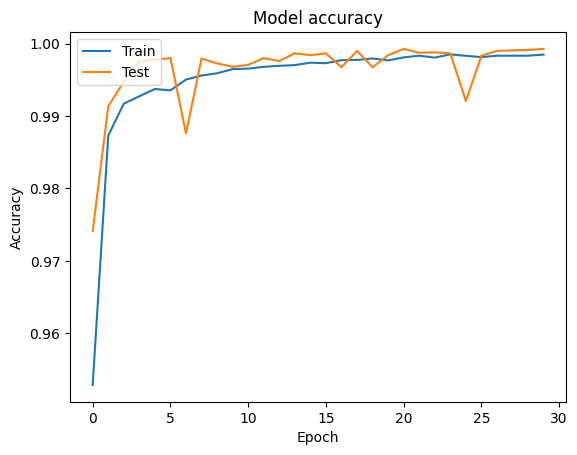

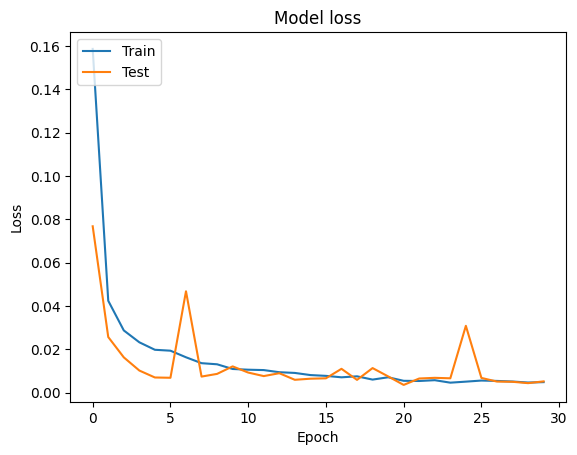

In [22]:
# Plot training & testing accuracy values
plt.plot(full_history_['accuracy'])
plt.plot(full_history_['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & testing loss values
plt.plot(full_history_['loss'])
plt.plot(full_history_['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

train_loss, train_accuracy = model.evaluate(train_generator)
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_accuracy}")

235/235 [==============================] - 6s 24ms/step - loss: 0.0053 - accuracy: 0.9993
Test Loss: 0.005252724979072809
Test Accuracy: 0.9992661476135254
937/937 [==============================] - 85s 90ms/step - loss: 0.0028 - accuracy: 0.9991
Train Loss: 0.0027718895580619574
Train Accuracy: 0.999082624912262


In [25]:
model.save('/content/drive/MyDrive/DSforBiz/6layerNN.keras')